# IPL: Exploratory Data Analysis (EDA)

In [84]:
#Importing Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#Loading Dataset
ball_df = pd.read_csv("D:/WsCube Tech/Capstone Project/IPL Capstone Project Assignment/IPL_BallByBall2008_2024(Updated).csv", dtype={2: str})
teams_df = pd.read_csv("D:/WsCube Tech/Capstone Project/IPL Capstone Project Assignment/ipl_teams_2024_info.csv")
players_df = pd.read_csv("D:/WsCube Tech/Capstone Project/IPL Capstone Project Assignment/Players_Info_2024.csv")
team_perf_df = pd.read_csv("D:/WsCube Tech/Capstone Project/IPL Capstone Project Assignment/team_performance_dataset_2008to2024.csv")

# Cleaning Data

In [4]:
# BallByBall 
ball_df.columns = ball_df.columns.str.strip().str.lower().str.replace(' ', '_')

ball_df['date'] = pd.to_datetime(ball_df['date'])

ball_df.drop(columns=['type_of_extras', 'wicket_type', 'fielders_involved'], inplace=True)

ball_df.drop_duplicates(inplace=True)

In [5]:
# Teams Info
teams_df.columns = teams_df.columns.str.strip().str.lower().str.replace(' ', '_')

teams_df['team_full_name'] = teams_df['team_full_name'].str.strip()

teams_df.drop_duplicates(inplace=True)

In [6]:
#Players Info
players_df.columns = players_df.columns.str.strip().str.lower().str.replace(' ', '_')

players_df['date_of_birth'] = pd.to_datetime(players_df['date_of_birth'], format='%d/%m/%Y', errors='coerce')

players_df['player_salary_clean'] = (
    players_df['player_salary']
    .str.extract(r'(\d+\.?\d*)')
    .astype(float)
)

players_df.drop_duplicates(inplace=True)

In [7]:
#Team Performance Summary
team_perf_df.columns = team_perf_df.columns.str.strip().str.lower().str.replace(' ', '_')

team_perf_df['date'] = pd.to_datetime(team_perf_df['date'], errors='coerce')

team_perf_df.drop_duplicates(inplace=True)

# Combining Data

In [78]:
# Merge Ball-by-Ball with Team Performance Data
combined_df = ball_df.merge(team_perf_df, on='match_id', how='left')

# Merge Striker Player Info
combined_df = combined_df.merge(
    players_df[['player_name', 'player_role', 'player_nationality', 'player_salary_clean']],
    left_on='striker',
    right_on='player_name',
    how='left'
).rename(columns={
    'player_role': 'striker_role',
    'player_nationality': 'striker_nationality',
    'player_salary_clean': 'striker_salary'
}).drop(columns=['player_name'])

# Merge Bowler Player Info
combined_df = combined_df.merge(
    players_df[['player_name', 'player_role']],
    left_on='bowler',
    right_on='player_name',
    how='left'
).rename(columns={'player_role': 'bowler_role'}).drop(columns=['player_name'])

# Drop matches without result (useful for ML)
ml_df = combined_df.dropna(subset=['match_winner'])

# Create Over Number from Ball Number
combined_df['over'] = (
    combined_df['ball_no'].astype(str).str.split('.').str[0].astype(int) + 1
)

# Assign Match Phase (Over Type)
combined_df['over_type'] = combined_df['over'].apply(
    lambda x: 'Powerplay' if x <= 6 else ('Death' if x > 15 else 'Middle')
)

# Make Over Type an Ordered Categorical Feature (useful for plotting)
combined_df['over_type'] = pd.Categorical(
    combined_df['over_type'],
    categories=['Powerplay', 'Middle', 'Death'],
    ordered=True
)

# 1️⃣ Run Trends Over the Years

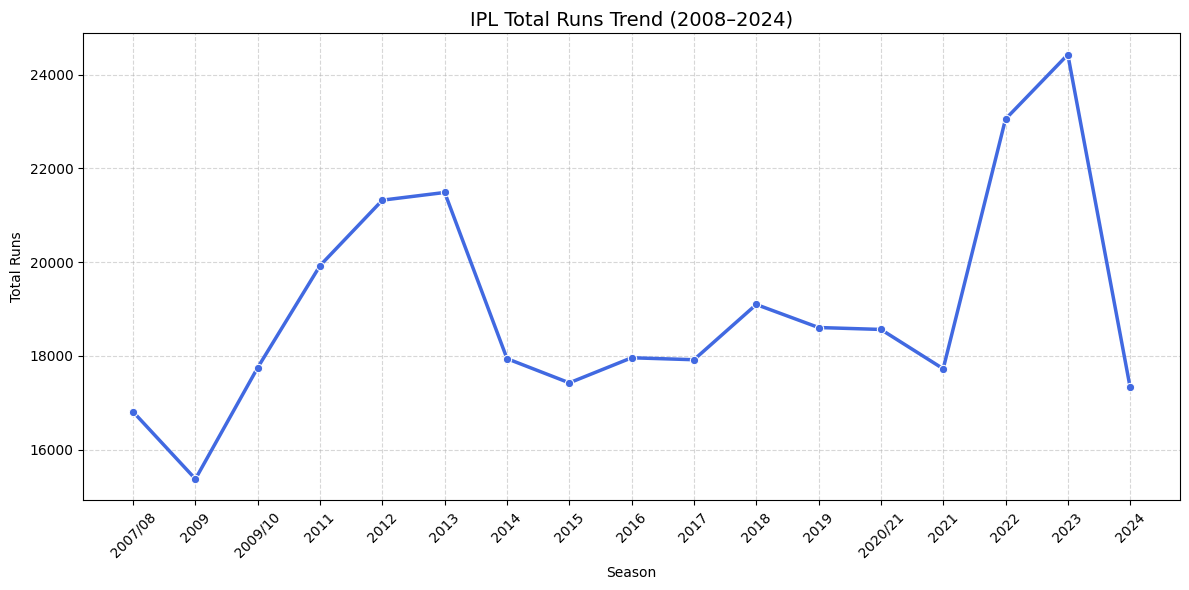

In [85]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=season_runs, x='season', y='runs_scored', marker='o', linewidth=2.5, color='royalblue')
plt.title('IPL Total Runs Trend (2008–2024)', fontsize=14)
plt.xlabel('Season')
plt.ylabel('Total Runs')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2️⃣ Compare Batting Styles (Anchor vs Aggressive)

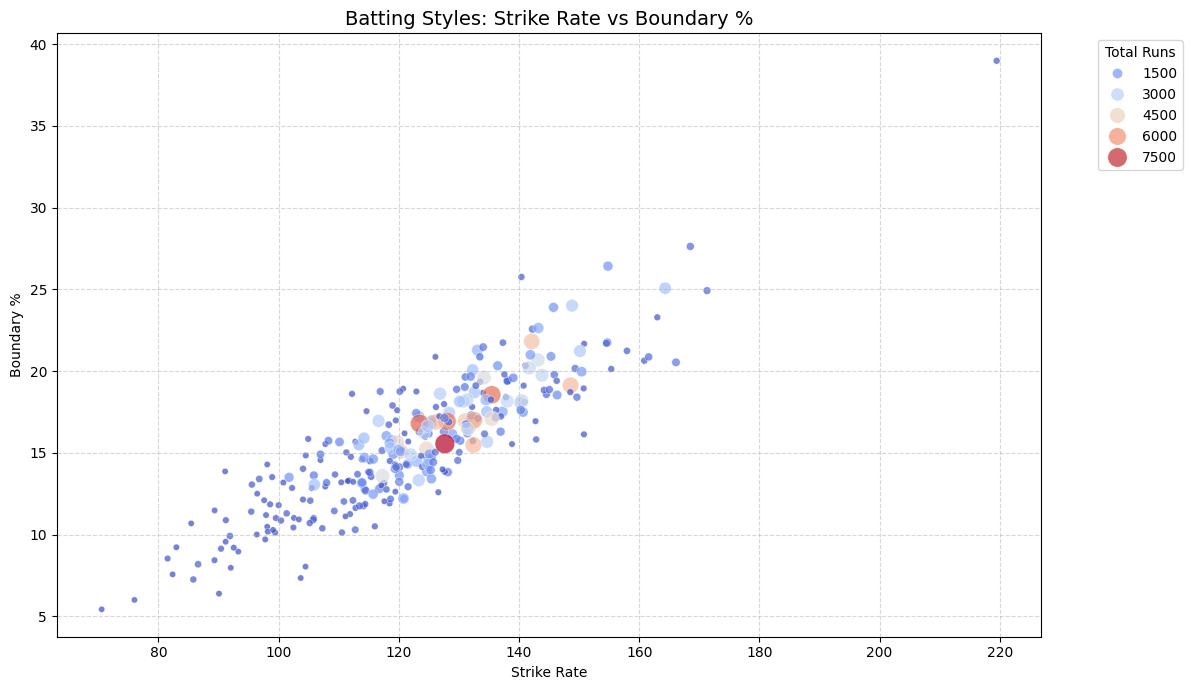

In [86]:
plt.figure(figsize=(12, 7))
sns.scatterplot(data=batting_stats, 
                x='strike_rate', 
                y='boundary_pct',
                size='runs_scored',
                hue='runs_scored',
                palette='coolwarm',
                alpha=0.7,
                sizes=(20, 200))

plt.title('Batting Styles: Strike Rate vs Boundary %', fontsize=14)
plt.xlabel('Strike Rate')
plt.ylabel('Boundary %')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Total Runs', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 3️⃣ Bowling Consistency (Dot Balls & Economy)

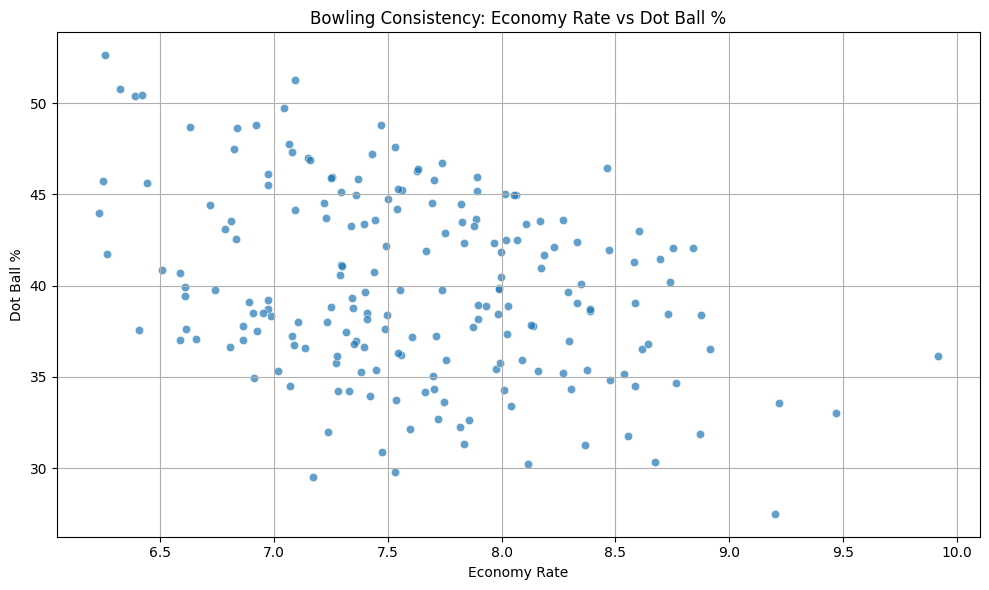

In [88]:
bowler_df = combined_df.copy()
bowler_df['is_dot'] = (bowler_df['runs_scored'] == 0).astype(int)

bowler_stats = bowler_df.groupby('bowler').agg({
    'runs_scored': 'sum',
    'is_dot': 'sum',
    'ball_no': 'count'
}).reset_index()

bowler_stats.rename(columns={'ball_no': 'balls_bowled'}, inplace=True)
bowler_stats['dot_pct'] = (bowler_stats['is_dot'] / bowler_stats['balls_bowled']) * 100
bowler_stats['economy'] = bowler_stats['runs_scored'] / (bowler_stats['balls_bowled'] / 6)

top_bowlers = bowler_stats[bowler_stats['balls_bowled'] > 300]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=top_bowlers, x='economy', y='dot_pct', alpha=0.7)
plt.title('Bowling Consistency: Economy Rate vs Dot Ball %')
plt.xlabel('Economy Rate')
plt.ylabel('Dot Ball %')
plt.grid(True)
plt.tight_layout()
plt.show()

# 4️⃣ Performance in Different Overs

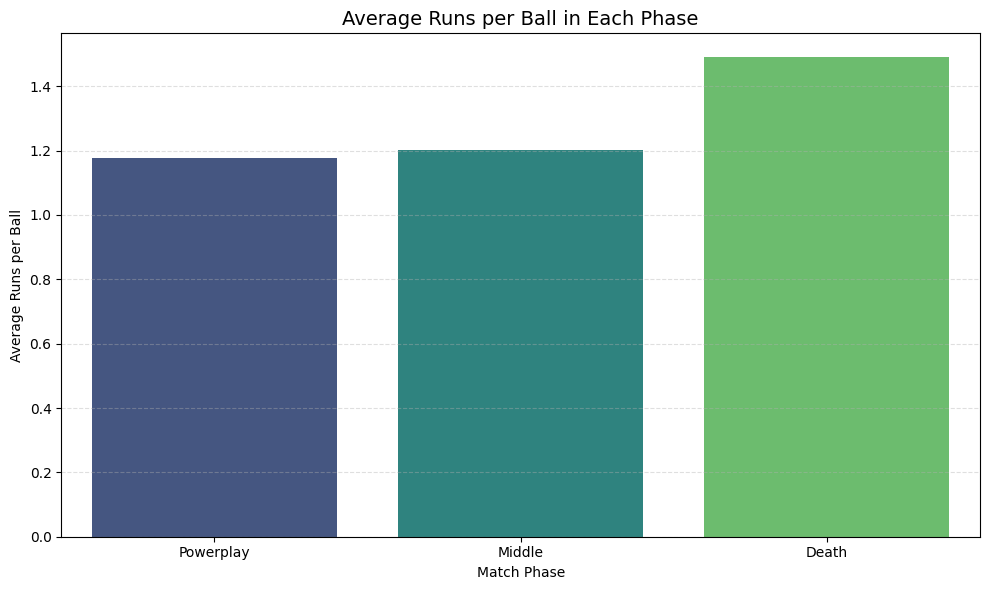

In [89]:
plt.figure(figsize=(10, 6))

sns.barplot(
    data=combined_df,
    x='over_type',
    y='runs_scored',
    hue='over_type',           
    palette='viridis',
    errorbar=None,               
    legend=False                  
)

plt.title('Average Runs per Ball in Each Phase', fontsize=14)
plt.xlabel('Match Phase')
plt.ylabel('Average Runs per Ball')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# 5️⃣ Venue Behavior in High/Low Scoring Matches

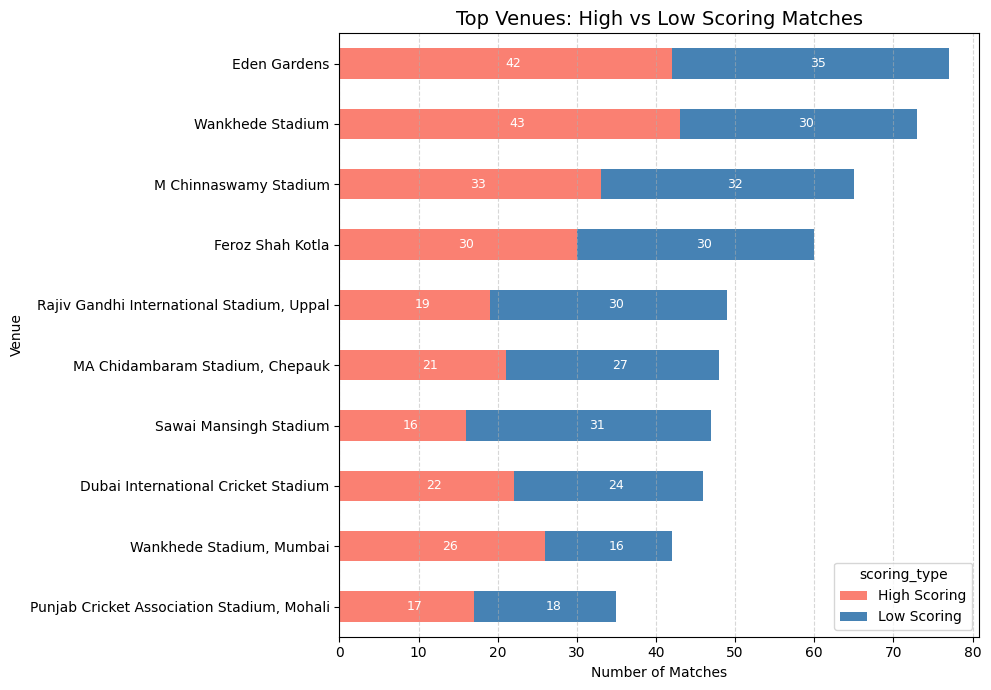

In [90]:
summary['Total'] = summary['High Scoring'] + summary['Low Scoring']
summary = summary.sort_values('Total', ascending=True).drop(columns='Total')

summary.plot(kind='barh', stacked=True, color=['salmon', 'steelblue'], figsize=(10, 7))

plt.title('Top Venues: High vs Low Scoring Matches', fontsize=14)
plt.xlabel('Number of Matches')
plt.ylabel('Venue')

for index, (high, low) in enumerate(zip(summary['High Scoring'], summary['Low Scoring'])):
    plt.text(high / 2, index, str(high), va='center', color='white', fontsize=9)
    plt.text(high + low / 2, index, str(low), va='center', color='white', fontsize=9)

plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()